# GRPO para Fine-tuning do Gemma-3 1B no GSM8K

# 1. Introdução

O **GRPO (Group Relative Policy Optimization)** é um algoritmo de Aprendizado por Reforço para treinar LLMs, introduzido pela DeepSeek-AI no artigo *DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models* como alternativa ao PPO. Ele preserva a ideia de atualização *clipped* e a regularização por divergência **KL**, mas elimina a necessidade de um *critic* (value network).

Em vez de usar uma rede de valor para calcular vantagem token-a-token, o GRPO gera um **grupo** de respostas para cada prompt e estima a vantagem a partir da média e do desvio-padrão das recompensas do grupo. Isso reduz custo computacional e memória. Neste projeto aplicamos GRPO para melhorar o desempenho do Gemma3-1B no GSM8K.

Este projeto foi inspirado no notebook da Unsloth **`https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Gemma3_(1B)-GRPO.ipynb`**.

# 2. Setup do ambiente e bibliotecas

Bibliotecas principais:

- **Unsloth**: carregamento eficiente do Gemma-3 e aplicação de LoRA.
- **TRL**: `GRPOTrainer` e `GRPOConfig`.
- **Transformers / PEFT**: tokenização, geração e carregamento de adaptadores LoRA.
- **Datasets**: carregamento do GSM8K.
- **PyTorch**: backend do treino e da avaliação.

Os parâmetros foram escolhidos para uma **RTX 4090**, para usar bastante VRAM (batch alto e `num_generations` relativamente grande). No entanto, os parâmetros do notebook atual são diferentes daqueles usados durante o treino. Isso foi feito para que seja possível executar o notebook inteiro dentro de um intervalo de tempo razoável.

**OBS**: Pode ser necessário ter uma GPU para rodar esse notebook. Caso contrário, a biblioteca Unsloth retornará erros.

In [1]:
%pip install unsloth vllm==0.10.2 torchvision bitsandbytes xformers triton transformers==4.56.2 trl==0.22.2 datasets

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import re
import torch

from unsloth import FastModel
from datasets import load_dataset
from trl import GRPOConfig, GRPOTrainer
from transformers import TextStreamer
from peft import PeftModel

import ast
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d

import builtins
from peft.tuners.lora import layer

print("torch:", torch.__version__)
print("cuda disponível:", torch.cuda.is_available())

builtins.VARIANT_KWARG_KEYS = layer.VARIANT_KWARG_KEYS

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/opt/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 12-15 05:09:40 [__init__.py:216] Automatically detected platform cuda.
🦥 Unsloth Zoo will now patch everything to make training faster!
torch: 2.8.0+cu128
cuda disponível: True


# 3. Prompt e pré-processamento do GSM8K

O dataset **GSM8K** contém problemas de matemática básica. As respostas vêm com o resultado final depois de `####`.  
No GRPO, transformamos cada exemplo em um formato de chat: `system prompt` + pergunta como mensagem do usuário.

O *system prompt* força o modelo a:
1. escrever um raciocínio entre `<start_working_out>` e `<end_working_out>`;
2. escrever a solução final entre `<SOLUTION>` e `</SOLUTION>`.

In [4]:
# Tokens especiais
reasoning_start = "<start_working_out>"
reasoning_end   = "<end_working_out>"
solution_start  = "<SOLUTION>"
solution_end    = "</SOLUTION>"

system_prompt = (
    "You are given a problem.\n"
    "Think about the problem and provide your working out.\n"
    f"Place it between {reasoning_start} and {reasoning_end}.\n"
    f"Then, provide your solution between {solution_start}{solution_end}"
)

# Extrai o número final do GSM8K (depois de ####)
def extract_hash_answer(text):
    if "####" not in text:
        return None
    return text.split("####")[1].strip()

# Mapeia dataset para formato de chat + answer numérica
def prepare_dataset(dataset):
    return dataset.map(lambda x: {
        "prompt": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": x["question"]},
        ],
        "answer": extract_hash_answer(x["answer"]),
    })

# Exemplo rápido
raw_train = load_dataset("openai/gsm8k", "main", split="train")
train_ds = prepare_dataset(raw_train)
print(train_ds[0]["prompt"])
print("answer:", train_ds[0]["answer"])

[{'content': 'You are given a problem.\nThink about the problem and provide your working out.\nPlace it between <start_working_out> and <end_working_out>.\nThen, provide your solution between <SOLUTION></SOLUTION>', 'role': 'system'}, {'content': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?', 'role': 'user'}]
answer: 72


# 4. Funções de recompensa

As recompensas são o núcleo do GRPO: elas avaliam cada geração do modelo. Usamos quatro funções:

1. **`match_format_exactly`**: recompensa máxima se o modelo segue exatamente o formato com tags.
2. **`match_format_approximately`**: recompensa parcial por aparecerem as tags corretas (penaliza falta/excesso).
3. **`check_answer`**: checagem estrita do conteúdo dentro de `<SOLUTION>`.
4. **`check_numbers`**: checagem mais leniente que aceita extração numérica em `$\\boxed{...}$` ou após `<SOLUTION>`.

Isso força o modelo a aprender **forma** (estrutura) e **conteúdo** (acerto numérico). Durante o desenvolvimento, essas funções foram validadas com um script de testes em `test_utils.py`.

In [5]:
# Regex para formato e extração de números
match_format = re.compile(
    rf"^[\s]{{0,}}"
    rf"{reasoning_start}.+?{reasoning_end}.*?"
    rf"{solution_start}(.+?){solution_end}"
    rf"[\s]{{0,}}$",
    flags=re.MULTILINE | re.DOTALL,
)

match_numbers = re.compile(
    rf"{solution_start}.*?([\d\.]{{1,}})",
    flags=re.MULTILINE | re.DOTALL,
)

match_boxed = re.compile(
    r"\$\\boxed\{([^}]+)\}\$",
    flags=re.MULTILINE | re.DOTALL,
)

def match_format_exactly(completions, **kwargs):
    scores = []
    for completion in completions:
        score = 0
        response = completion[0]["content"]
        if match_format.search(response) is not None:
            score += 3.0
        scores.append(score)
    return scores

def match_format_approximately(completions, **kwargs):
    scores = []
    for completion in completions:
        score = 0
        response = completion[0]["content"]
        score += 0.5 if response.count(reasoning_start) == 1 else -0.5
        score += 0.5 if response.count(reasoning_end)   == 1 else -0.5
        score += 0.5 if response.count(solution_start)  == 1 else -0.5
        score += 0.5 if response.count(solution_end)    == 1 else -0.5
        scores.append(score)
    return scores

def check_answer(prompts, completions, answer, **kwargs):
    """
    Checagem estrita:
    - espera resposta apenas entre <SOLUTION> tags.
    - recompensa maior para match exato, menor para whitespace, menor ainda para ratio próximo.
    """
    responses = [completion[0]["content"] for completion in completions]
    extracted_responses = [
        guess.group(1) if (guess := match_format.search(r)) is not None else None
        for r in responses
    ]

    scores = []
    for guess, true_answer in zip(extracted_responses, answer):
        score = 0
        if guess is None:
            scores.append(0)
            continue
        if guess == true_answer:
            score += 3.0
        elif guess.strip() == true_answer.strip():
            score += 1.5
        else:
            try:
                ratio = float(guess) / float(true_answer)
                if   0.9 <= ratio <= 1.1: score += 0.5
                elif 0.8 <= ratio <= 1.2: score += 0.25
                else: score -= 1.0
            except:
                score -= 0.5
        scores.append(score)
    return scores

def check_numbers(prompts, completions, answer, **kwargs):
    """
    Checagem leniente:
    - procura primeiro por $\\boxed{...}$ (última ocorrência),
    - senão extrai o primeiro número após <SOLUTION>.
    """
    responses = [completion[0]["content"] for completion in completions]

    extracted_responses = []
    for r in responses:
        boxed_matches = match_boxed.findall(r)
        if boxed_matches:
            extracted_responses.append(boxed_matches[-1])
            continue
        guess = match_numbers.search(r)
        extracted_responses.append(guess.group(1) if guess is not None else None)

    scores = []
    for guess, true_answer in zip(extracted_responses, answer):
        if guess is None:
            scores.append(0)
            continue
        try:
            true_answer = float(true_answer.strip())
            guess = float(guess.strip())
            scores.append(1.5 if guess == true_answer else 0.0)
        except:
            scores.append(0)
    return scores

# 5. Treinamento com GRPO + LoRA

O treino está no `train.py`. O fluxo é:

1. Carregar o modelo base `unsloth/gemma-3-1b-it` em FP16.
2. Adicionar LoRA (rank=8) nas camadas principais.
3. Preparar o GSM8K `train`.
4. Configurar GRPO (batch 48, `num_generations=8`, seq 2048).
5. Treinar com `trainer.train()`.

Setup experimental (como apresentado nos slides): GSM8K **train** com 7.473 problemas; Gemma-3 1B Instruct com LoRA (rank=8) e `max_seq_length=2048`; `per_device_train_batch_size=48` e `num_generations=8`. O treino foi feito em uma RTX 4090 por 1 época completa (~41h).

**Observação:** em CPU esse treino não é viável; requer GPU.

In [7]:
# Setup do modelo
max_seq_length = 2048

model, tokenizer = FastModel.from_pretrained(
    model_name="unsloth/gemma-3-1b-it",
    max_seq_length=max_seq_length,
    load_in_4bit=False,
    load_in_8bit=False,
    load_in_16bit=True,
    full_finetuning=False,
)

model = FastModel.get_peft_model(
    model,
    finetune_vision_layers=False,
    finetune_language_layers=True,
    finetune_attention_modules=True,
    finetune_mlp_modules=True,
    r=8,
    lora_alpha=8,
    lora_dropout=0,
    bias="none",
    random_state=3407,
)

# Carregamento dos dados e preparação
dataset = load_dataset("openai/gsm8k", "main", split="train")
dataset = prepare_dataset(dataset)

# Configuração de treino
max_prompt_length = 256
training_args = GRPOConfig(
    learning_rate=5e-6,
    adam_beta1=0.9,
    adam_beta2=0.99,
    weight_decay=0.1,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    optim="adamw_torch_fused",
    logging_steps=1,
    per_device_train_batch_size=1, # Numa 4090, coloque 48
    gradient_accumulation_steps=1,
    num_generations=2, # Numa 4090, coloque 8
    max_prompt_length=max_prompt_length,
    max_completion_length=max_seq_length - max_prompt_length,
    num_train_epochs=1,
    max_steps=3, # remova isso para treinar uma época inteira
    save_steps=50,
    max_grad_norm=0.1,
    report_to="none",
    output_dir="outputs",
)

trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[
        match_format_exactly,
        match_format_approximately,
        check_answer,
        check_numbers,
    ],
    args=training_args,
    train_dataset=dataset,
)

# Treino
trainer.train()

# Salvar modelo e tokenizer
model.save_pretrained("gemma-3")
tokenizer.save_pretrained("gemma-3")

# Salvar log de treino (compatível com parse_and_plot_training_log)
with open("training.log", "w") as f:
    for entry in trainer.state.log_history:
        f.write(str(entry) + "\n")

==((====))==  Unsloth 2025.11.1: Fast Gemma3 patching. Transformers: 4.56.2. vLLM: 0.10.2.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.691 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3 does not support SDPA - switching to fast eager.
Unsloth: Making `model.base_model.model.model` require gradients
Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 2


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 7,473 | Num Epochs = 1 | Total steps = 3
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 1 x 1) = 2
 "-____-"     Trainable parameters = 6,522,880 of 1,006,408,832 (0.65% trained)


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / match_format_exactly / mean,rewards / match_format_exactly / std,rewards / match_format_approximately / mean,rewards / match_format_approximately / std,rewards / check_answer / mean,rewards / check_answer / std,rewards / check_numbers / mean,rewards / check_numbers / std
1,0.000000,-0.250000,1.060660,1307.000000,822.000000,1792.000000,0.500000,822.000000,822.000000,822.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.750000,1.060660
2,0.000000,-1.000000,0.000000,1387.500000,1040.000000,1735.000000,0.000000,1387.500000,1040.000000,1735.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,1.250000,1.767767,449.500000,281.000000,618.000000,0.000000,449.500000,281.000000,618.000000,0.000427,0.000000,0.000000,0.500000,0.707107,0.000000,0.000000,0.750000,1.060660


Unsloth: Will smartly offload gradients to save VRAM!


# 6. Visualização das métricas de treino

O TRL imprime métricas por step no `training.log`.  
O script `visualization.py` parseia esses dicionários e cria um painel de plots (loss, KL, recompensas etc.).

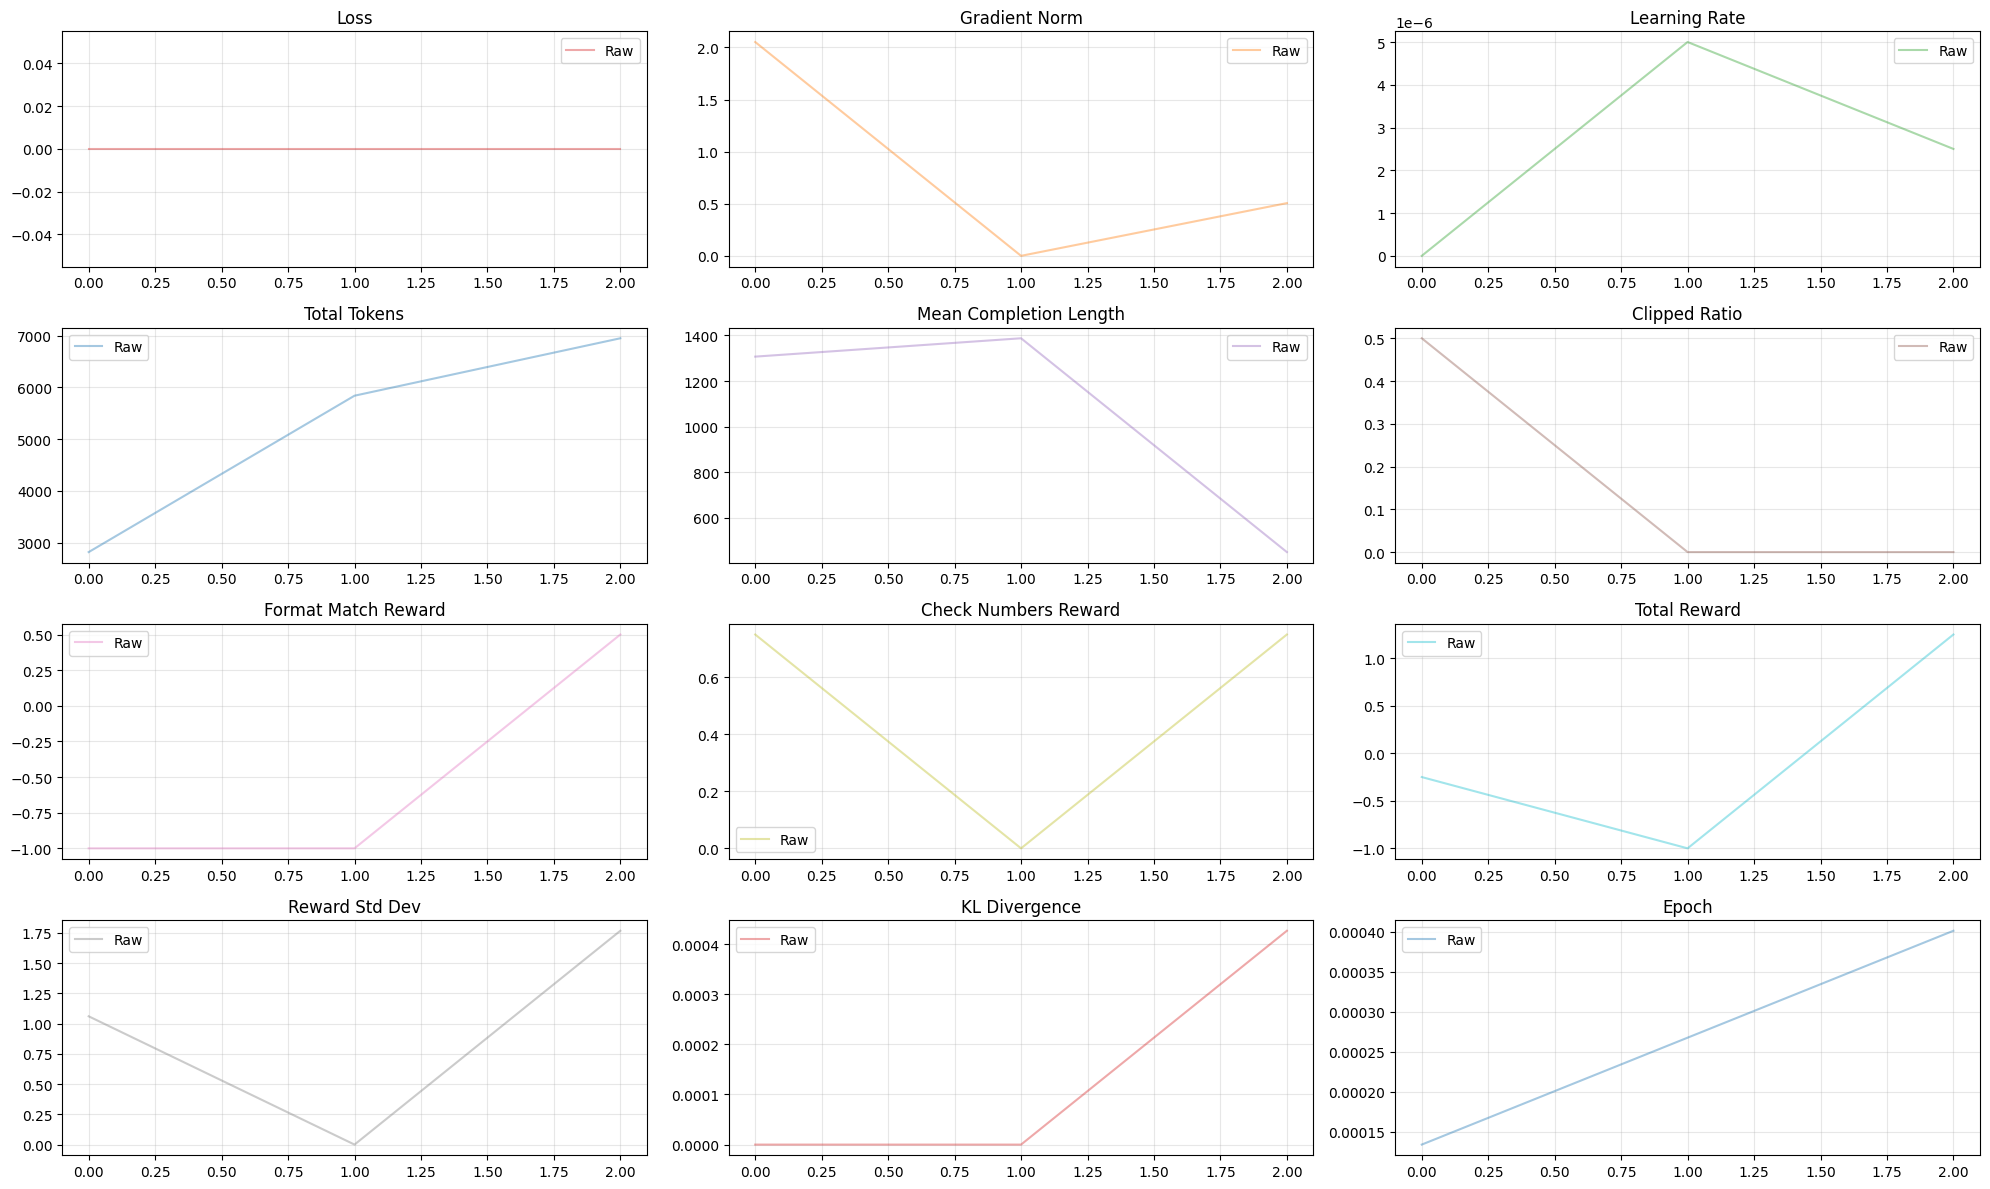

In [8]:
def parse_and_plot_training_log(log_file_path):
    with open(log_file_path, "r", encoding="utf-8") as f:
        log_text = f.read()

    pattern = r"\{'loss':.*?\}"
    matches = re.findall(pattern, log_text, re.DOTALL)

    metrics_list = []
    for match in matches:
        try:
            metrics_list.append(ast.literal_eval(match))
        except Exception:
            continue

    fig = plt.figure(figsize=(20, 12))
    steps = list(range(len(metrics_list)))

    plots_config = [
        ("loss", "Loss", "tab:red"),
        ("grad_norm", "Gradient Norm", "tab:orange"),
        ("learning_rate", "Learning Rate", "tab:green"),
        ("num_tokens", "Total Tokens", "tab:blue"),
        ("completions/mean_length", "Mean Completion Length", "tab:purple"),
        ("completions/clipped_ratio", "Clipped Ratio", "tab:brown"),
        ("rewards/match_format_approximately/mean", "Format Match Reward", "tab:pink"),
        ("rewards/check_numbers/mean", "Check Numbers Reward", "tab:olive"),
        ("reward", "Total Reward", "tab:cyan"),
        ("reward_std", "Reward Std Dev", "tab:gray"),
        ("kl", "KL Divergence", "tab:red"),
        ("epoch", "Epoch", "tab:blue"),
    ]

    for idx, (key, title, color) in enumerate(plots_config, 1):
        ax = plt.subplot(4, 3, idx)
        values = [m.get(key, None) for m in metrics_list]
        valid = [(i, v) for i, v in enumerate(values) if v is not None]
        if valid:
            valid_steps, valid_values = zip(*valid)
            ax.plot(valid_steps, valid_values, color=color, alpha=0.4, label="Raw")
            if len(valid_values) > 5:
                window_size = min(max(5, len(valid_values) // 20), len(valid_values))
                smoothed = uniform_filter1d(valid_values, size=window_size)
                ax.plot(valid_steps, smoothed, color=color, linewidth=2.5, label="Smoothed")
            ax.grid(True, alpha=0.3)
            ax.set_title(title)
            ax.legend()
        else:
            ax.set_title(title)
            ax.text(0.5, 0.5, f"No data for {key}", ha="center")

    plt.tight_layout()
    return metrics_list, fig

# Plota métricas de treino (descomente após treinar)
metrics, fig = parse_and_plot_training_log("training.log")
plt.show()

# 7. Avaliação no split de teste

A avaliação (`eval.py`) compara:

- **modelo base** `unsloth/gemma-3-1b-it`;
- **modelo GRPO** = base + adaptadores LoRA salvos.

O split **test** do GSM8K tem 1.319 questões.  
Para cada questão, geramos uma resposta, extraímos o número final e comparamos com o gabarito.

In [12]:
# Configuração principal
NUM_SAMPLES = 1 # Coloque 1319 para testar com o split de teste inteiro
BATCH_SIZE = 256
SEED = 42
RUN_EVAL = True  # mude para True para executar

# Parâmetros de geração
TEMPERATURE = 1.0
TOP_P = 0.95
TOP_K = 64
MAX_NEW_TOKENS = 1792   # 2048 - 256
MAX_PROMPT_LENGTH = 256

# Modelos
BASE_MODEL_NAME = "unsloth/gemma-3-1b-it"
GRPO_ADAPTER_PATH = "gemma-3/"

# Observação: este bloco assume que `system_prompt` e `extract_hash_answer`
# foram definidos na seção 3 deste documento.

match_boxed = re.compile(r"\$\\boxed\{([^}]+)\}\$", flags=re.MULTILINE | re.DOTALL)
match_any_number = re.compile(r"[\d\.]+")

In [10]:
def load_base_model():
    model, tokenizer = FastModel.from_pretrained(
        model_name=BASE_MODEL_NAME,
        max_seq_length=2048,
        load_in_4bit=False,
        load_in_8bit=False,
        load_in_16bit=True,
        full_finetuning=False,
    )
    model.eval()
    return model, tokenizer


def load_grpo_model():
    model, tokenizer = load_base_model()
    model = PeftModel.from_pretrained(model, GRPO_ADAPTER_PATH, is_trainable=False)
    model.eval()
    return model, tokenizer


def load_and_prepare_dataset(num_samples, seed=42):
    ds = load_dataset("openai/gsm8k", "main", split="test")
    if num_samples < len(ds):
        ds = ds.shuffle(seed=seed).select(range(num_samples))
    ds = ds.map(lambda x: {
        "prompt": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": x["question"]},
        ],
        "answer": extract_hash_answer(x["answer"]),
        "question": x["question"],
    })
    return ds


def extract_answer(response):
    boxed = match_boxed.findall(response)
    if boxed:
        nums = match_any_number.findall(boxed[-1])
        return (nums[-1] if nums else boxed[-1]), "boxed"
    if "<SOLUTION>" in response:
        part = response.split("<SOLUTION>", 1)[1]
        if "</SOLUTION>" in part:
            part = part.split("</SOLUTION>", 1)[0]
        nums = match_any_number.findall(part)
        if len(nums) == 1: return nums[0], "solution_single"
        if len(nums) > 1: return nums[-1], "solution_multiple"
        return None, "solution_no_number"
    nums = match_any_number.findall(response)
    if nums: return nums[-1], "last_number"
    return None, "no_number"


def evaluate_answer(extracted, truth):
    if extracted is None: return False
    try:
        return abs(float(extracted) - float(truth)) < 1e-6
    except Exception:
        return str(extracted).strip() == str(truth).strip()

In [11]:
def generate_batch(model, tokenizer, prompts, batch_size=8):
    generations = []
    for i in range(0, len(prompts), batch_size):
        batch = prompts[i:i+batch_size]
        texts = [
            tokenizer.apply_chat_template(p, add_generation_prompt=True, tokenize=False)
            for p in batch
        ]
        inputs = tokenizer(
            texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=MAX_PROMPT_LENGTH,
        ).to("cuda")

        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            temperature=TEMPERATURE,
            top_p=TOP_P,
            top_k=TOP_K,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
        )

        for j, out in enumerate(outputs):
            input_len = inputs["input_ids"][j].shape[0]
            generations.append(
                tokenizer.decode(out[input_len:], skip_special_tokens=True)
            )
    return generations


def evaluate_model(model, tokenizer, dataset, batch_size=8, name="base"):
    prompts = [ex["prompt"] for ex in dataset]
    truths  = [ex["answer"] for ex in dataset]
    gens = generate_batch(model, tokenizer, prompts, batch_size=batch_size)

    correct = 0
    for g, t in zip(gens, truths):
        extracted, _ = extract_answer(g)
        if evaluate_answer(extracted, t):
            correct += 1

    acc = correct / len(dataset) * 100
    return {"accuracy": acc, "num_correct": correct, "num_examples": len(dataset)}

In [ ]:
if RUN_EVAL:
    ds_test = load_and_prepare_dataset(NUM_SAMPLES, SEED)

    base_model, tok = load_base_model()
    base_res = evaluate_model(base_model, tok, ds_test, BATCH_SIZE, "base")
    del base_model
    torch.cuda.empty_cache()

    grpo_model, tok = load_grpo_model()
    grpo_res = evaluate_model(grpo_model, tok, ds_test, BATCH_SIZE, "grpo")

    print(base_res)
    print(grpo_res)

    base_accuracy = base_res["accuracy"]
    grpo_accuracy = grpo_res["accuracy"]

    fig, ax = plt.subplots(figsize=(8, 6))
    models = ["Base", "GRPO"]
    accuracies = [base_accuracy, grpo_accuracy]
    colors = ["#3498db", "#2ecc71"]

    bars = ax.bar(models, accuracies, color=colors, width=0.5)
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            h,
            f"{h:.2f}%",
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight="bold",
        )

    ax.set_ylabel("Performance (%)")
    ax.set_title("Comparação de Performance no GSM8K")
    ax.set_ylim(0, 70)
    ax.grid(axis="y", alpha=0.3, linestyle="--")
    plt.show()
else:
    print("Defina RUN_EVAL=True para rodar a avaliação e gerar o gráfico.")

Map: 100%|██████████| 1/1 [00:00<00:00, 163.03 examples/s]


==((====))==  Unsloth 2025.11.1: Fast Gemma3 patching. Transformers: 4.56.2. vLLM: 0.10.2.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.691 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3 does not support SDPA - switching to fast eager.
==((====))==  Unsloth 2025.11.1: Fast Gemma3 patching. Transformers: 4.56.2. vLLM: 0.10.2.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.691 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore dow

# 8. Conclusão

O fine-tuning por **GRPO + LoRA** trouxe um ganho de cerca de **2.5 p.p.** de acurácia no GSM8K para o Gemma-3 1B.  
Mesmo com recompensas relativamente simples (formato + correção numérica), o modelo passa a respeitar melhor a estrutura de raciocínio e melhorar a resposta final.